# Data processing and stochastic modelization

In [1]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

RERUN = False #To rerun all computations (False will load from file if they exist)
NCORES_MAX = 4 #Maximal number of cores in use
extension = '.png' #fig file extension
#DIR  = 'D:/pdm_data/' #On desktop
DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/' #On laptop

In [2]:
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}

In [3]:
#Skew-normal PDF
def p_skew(v,sample) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p

def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    return MP_dict

def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(DIR),len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        p_dict[p_] = float(v_)
    return p_dict

# Loading and processing DNS data

##### Computing Ux mean from Eulerian velocities

In [4]:
UMEAN = {}
Ndat  = 1000
if (not os.path.isfile(DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')) :
    phi   = Bentheimer1000['phi']
    print('-load ux data..')
    ux    = np.loadtxt(DIR+'Bentheimer'+str(Ndat)+'/Ux.dat')
    print('-Ux dimensions : '+str(np.shape(ux)))
 
    #First method to find Umean (direct mesh computation)
    print('-first method..')
    Umean = np.mean(ux[:][0]) #Mean flow velocity as the mean over the first yz section of the domain
    UMEAN['dmc'] = [Umean]

    #Second method (From Fortran code)
    print('-reshaping ux..')
    uux = ux.reshape(Ndat**3)
    del ux
    Umean = 0
    print('-second method..')
    for (i2,i3) in zip(range(Ndat),range(Ndat)) :
        i1 = 0
        Umean += uux[Ndat*Ndat*i3 + Ndat*i2 + i1]
    Umean = Umean/(Ndat**2)/phi
    UMEAN['fortran'] = [Umean]
    Save_data(UMEAN,DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')
    del uux
else :
    UMEAN = Load_data(DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')
    
print('=> Umean fortran = ' + str(UMEAN['fortran']) + '\t Umean dmc = ' + str(UMEAN['dmc']))
Umean = UMEAN['fortran'][0]

=> Umean fortran = [2.4514361e-09]	 Umean dmc = [7.17953958e-09]


In [5]:
np.log(Umean)

-19.826591821550718

#### Data files 

In [6]:
DATA = {}

DM_ = ['0.0E0',
       '1.0E-13',
       '2.0E-13', 
       '5.0E-13', 
       '1.0E-12',
       '2.0E-12', 
       '5.0E-12', 
       '1.0E-11', 
       '2.0E-11', 
       '5.0E-11', 
       '1.0E-10',
       '2.0E-10',
       '5.0E-10',
       '1.0E-9',
       '1.0E-8',
       '1.0E-7',
       '1.0E-6',
       '1.0E-5']
KEYS   = ['Bent 1000, D='+dm+', CSF=20' for dm in DM_] #ORDERED ARRAY OF KEYS (IMPORTANT TO SORT DATA)
PLOT_KEYS = ['Bent 1000, D='+dm_+', CSF=20' for dm_ in ['0.0E0','1.0E-13','1.0E-12','1.0E-11','1.0E-10','1.0E-9','1.0E-8','1.0E-7','1.0E-6','1.0E-5']]

CASE   = 'Bentheimer1000'
for dm in DM_ : DATA['Bent 1000, D='+dm+', CSF=20'] = DIR+CASE+'/sl_out_M0_DM'+dm+'_SLSM0_TMAX2.0E7_CSF40.dat'

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
COLORS = {key : color for (key,color) in zip(PLOT_KEYS,color_cycle)}
print('Dataset to load : ' +str(len(DATA)))
PARAM = {}
param = ['DM','SLSM','TMAX','CSF']
for key in DATA : PARAM[key] = Extract_param (DATA[key],param)
D_VALUES = [PARAM[key]['DM'] for key in KEYS]

Dataset to load : 18


In [7]:
for key in DATA :
    if not os.path.isfile(DATA[key]) :
        print('Warning file from key : ' + key + 'not found')

#### Computing log velocity magnitude $$v = \ln{\left(\frac{\sqrt{u_x^2 + u_y^2 + u_z^2}}{U}\right)}$$

In [8]:
vDNS = {}; vfname = DIR+'Processed_data/vDNS.dat'
tDNS = {}; tfname = DIR+'Processed_data/tDNS.dat'
if os.path.isfile(vfname) and os.path.isfile(tfname) and (not RERUN): 
    print('Loading vDNS...')
    vDNS = Load_data(vfname)
    print('Done.')
    print('Loading tDNS...')
    tDNS = Load_data(tfname)
    print('Done.')
else :
    print('Checking if new data file...')
    RESAVE = False
    for key in KEYS :
        if key not in vDNS :
            RESAVE = True
            print("missing " + key + "data..")
            with open(DATA[key], 'r') as f:
                dataDNS = np.genfromtxt((line for line in f if (len(line)>100 and len(line)<150)))
            tDNS[key] = dataDNS[:,0]
            print(key + '\t: NtDNS = '+str(len(tDNS[key])))
            vDNS[key] = np.array(
                [np.log(np.sqrt(ux**2+uy**2+uz**2)) 
                    for (ux,uy,uz) in zip(dataDNS[:,4], dataDNS[:,5], dataDNS[:,6]) 
                    if np.sqrt(ux**2+uy**2+uz**2) > 0])        
    if RESAVE :
        print('Saving...')
        Save_data(vDNS,DIR+'Processed_data/vDNS.dat')
        Save_data(tDNS,DIR+'Processed_data/tDNS.dat')
        print('Done.')

Loading data...
Done.
Checking if new data file...
Done.


#### Overview of the rough DNS time

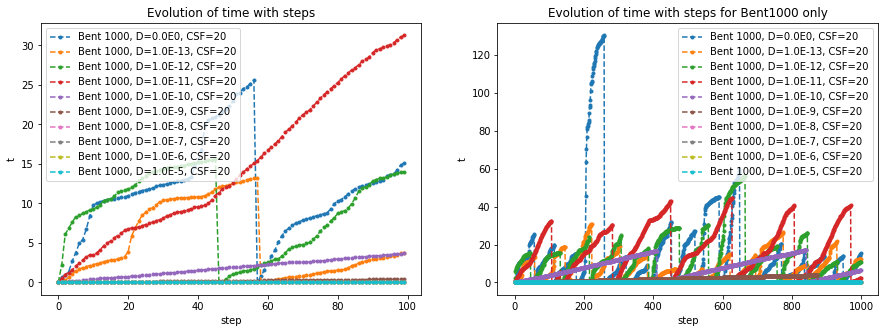

In [16]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].set_title('Evolution of time with steps');
for key in PLOT_KEYS : axs[0].plot(tDNS[key][range(100)],'.--', label = key);
axs[0].set_xlabel('step');
axs[0].set_ylabel('t');
axs[0].legend();

axs[1].set_title('Evolution of time with steps for Bent1000 only');
for key in PLOT_KEYS : axs[1].plot(tDNS[key][range(1000)],'.--', label = key);
axs[1].set_xlabel('step');
axs[1].set_ylabel('t');
axs[1].legend();
plt.savefig(DIR+'Figures/DNS_time'+extension)

## Making DNS data isochronous

### 1) Single streamline transform (ssl)

In [17]:
def ssl_transform(N,t,v) :
    dt      = [t1-t0 for (t1,t0) in zip(t[range(1,N)],t[range(N-1)])]
    dt_ssl  = [dt_ for dt_ in dt if dt_ > 0] #filtering
    N_ssl   = len(dt_ssl)
    t_ssl   = np.zeros(N_ssl)
    v_ssl   = np.zeros(N_ssl)
    #t_ssl  = [t_ssl[i-1] + dt_ssl[i] for i in range(1,N_ssl)]
    T = 0.0
    for i in range(N_ssl) :
        t_ssl[i] = T
        T += dt_ssl[i]
        v_ssl[i] = v[i]
    return t_ssl, v_ssl

In [18]:
dicts      = [{},{}]
v_ssl   = dicts[0]; vsslfname   = DIR+'Processed_data/v_ssl.dat'
t_ssl   = dicts[1]; tsslfname   = DIR+'Processed_data/t_ssl.dat'
fnames     = [vsslfname, tsslfname]

for i in range(len(fnames)) :
    name_ = fnames[i]
    if os.path.isfile(name_): 
        print('Loading ' + name_ + '..')
        dicts[i] = Load_data(name_)
    else : 
        print('Missing ' + name_ + '..')
        MISSING = True
    print('Done.')
v_ssl   = dicts[0];
t_ssl   = dicts[1];

RESAVE = False
print('Checking if new data file...')
for key in DATA :
    if key not in v_ssl :
        RESAVE = True
        print("missing " + key + "data..")
        Npoints = len(tDNS[key]) #For the full data set
        t_ssl[key], v_ssl[key] = ssl_transform (Npoints, tDNS[key], vDNS[key])
        print (key + '\t Npoints = '+str(Npoints))
        print('t_ssl : '+str(len(t_ssl[key]))+', v_ssl : ' + str(len(v_ssl[key])))
    print('Done.')
if RESAVE :
    print('Saving '+vsslfname+'...')
    Save_data(v_ssl,vsslfname)
    print('Saving '+tsslfname+'...')
    Save_data(t_ssl,tsslfname)
    print('Done.')    

Loading C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/Processed_data/v_ssl.dat..
Done.
Loading C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/Processed_data/t_ssl.dat..
Done.
Checking if new data file...


#### Distribution of time step 

In [ ]:
def time_step_analysis(t_ssl,key) :
    dt         = [t1-t0 for (t1,t0) in zip(t_ssl[1:],t_ssl[:-1]) if t1-t0 > 0]
    dt_hist    = Extract_pdf(dt,50)
    dtDNS_mean = np.mean(dt)
    dtDNS_std  = np.std(dt)
    return (key, dt_hist, dtDNS_mean, dtDNS_std)
    
def parallel_time_step_analysis(t_dict) :
    dt_hist        = {}
    dtDNS_mean     = {}
    dtDNS_std      = {}
    results  = Parallel(n_jobs=NCORES_MAX)(delayed(time_step_analysis)(t_dict[key],key) for key in KEYS)
    for (k_,h_,m_,s_) in results :
        dt_hist[k_]    = h_.tolist()
        dtDNS_mean[k_] = [m_]
        dtDNS_std[k_]  = [s_]
    return dt_hist, dtDNS_mean, dtDNS_std

In [ ]:
dt_histfname = DIR+'Processed_data/dt_hist.dat'
dtmeanfname  = DIR+'Processed_data/dt_mean.dat'
dtstdfname   = DIR+'Processed_data/dt_std.dat'

if RERUN :
    start = time.time()
    dt_hist, dtDNS_mean, dtDNS_std = parallel_time_step_analysis(t_ssl)
    end = time.time()
    print('\tTime needed \t: '+str(end-start))
    print('Saving '+dt_histfname+'...')
    Save_pdf(dt_hist,dt_histfname)
    print('Saving '+dtmeanfname+'...')
    Save_data(dtDNS_mean,dtmeanfname)
    print('Saving '+dtstdfname+'...')
    Save_data(dtDNS_std,dtstdfname)
    print('Done.') 
else :
    print('Loading data...')
    dt_hist    = Load_pdf(dt_histfname)
    dtDNS_mean = Load_data(dtmeanfname)
    dtDNS_std  = Load_data(dtstdfname)
    print('Done.')

Loading data...
Done.


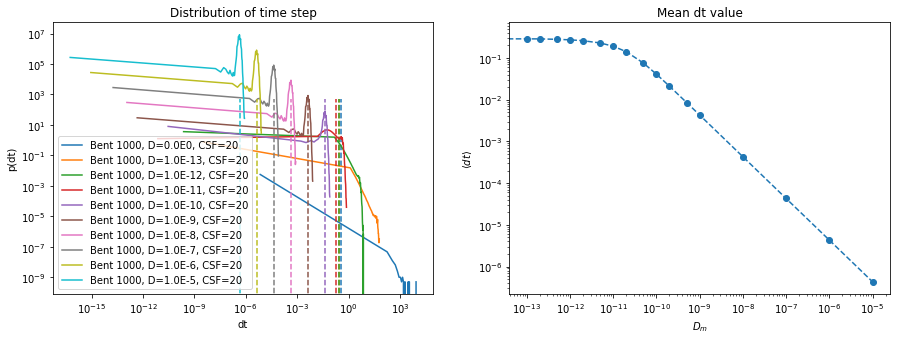

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

k_ = 0
for key in PLOT_KEYS :
    axs[0].plot(dt_hist[key][0],dt_hist[key][1], label = key, color = color_cycle[k_])
    axs[0].plot(np.ones(2) * dtDNS_mean[key],np.linspace(0,500,2),'--', color = color_cycle[k_])
    k_ += 1
axs[0].set_title('Distribution of time step');
axs[0].set_xlabel('dt')
axs[0].set_ylabel('p(dt)')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend();

axs[1].set_title('Mean dt value')
axs[1].plot(D_VALUES,[dtDNS_mean[k_] for k_ in KEYS],'o--')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$D_m$')
axs[1].set_ylabel(r'$\langle dt \rangle$')


plt.savefig(DIR+'Figures/DNS_dt_distribution'+extension)

#### Overview of the ssl transformed DNS serie

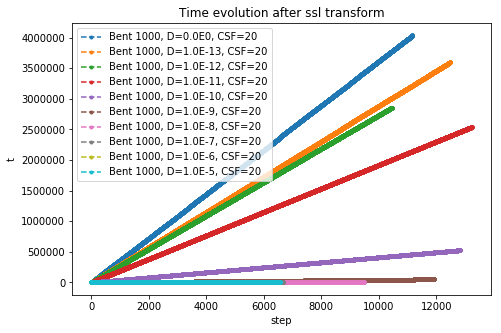

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7.5,5))

ax.set_title('Time evolution after ssl transform')
for key in PLOT_KEYS : ax.plot(t_ssl[key][range(0,len(t_ssl[key]),1000)],'.--', label = key);
ax.set_xlabel('step');
ax.set_ylabel('t');
ax.legend();
plt.savefig(DIR+'Figures/DNS_time_iso'+extension)

#### Isochronous transform of DNS data

In [ ]:
#pointwise linear interpolation
def lin_interp(v1,t1,v0,t0,t) :
    v = v0 + (v1-v0) * (t-t0)/(t1-t0)
    return v
#Alternative version (parallel over dict keys) :
def isochronous_transform(t_serie, v_serie, dt, key, Npoints) :
    if Npoints == 'all' :
        N = len(t_serie)-1
    elif 0 < Npoints <= 1 :
        N = int(Npoints * (len(t_serie)-1))
    else :
        N = Npoints
    Nt_iso   = int(np.ceil(t_serie[N]/dt))
    v_iso    = np.zeros(Nt_iso)
    
    m = 0; i = 0; ti = 0;
    while(m < N-1) :
        t1 = t_serie[m+1]; t0 = t_serie[m]
        v1 = v_serie[m+1]; v0 = v_serie[m]
        while (t0 <= ti <= t1) :
            v_iso[i]  = lin_interp(v1,t1,v0,t0,ti)
            ti += dt; i += 1
        m = m + 1
    return (key,v_iso)

def parallel_isochronous_transform(t_dict, v_dict, dt_dict, Npoints, dt_factor) :
    v_iso    = Parallel(n_jobs=NCORES_MAX)(
        delayed(isochronous_transform)
        (t_dict[key], v_dict[key], dt_dict[key][0] * dt_factor, key, Npoints) for key in KEYS)
    v_iso_dict = {}
    for (key,v_) in v_iso :
        v_iso_dict[key] = v_.tolist()
    return v_iso_dict

def sequential_isochronous_transform(t_dict, v_dict, dt_dict, Npoints, dt_factor) :
    v_iso = [isochronous_transform(t_dict[key], v_dict[key], dt_dict[key] * dt_factor, key, Npoints) for key in KEYS]
    v_iso_dict = {}
    for (key,v_) in v_iso :
        v_iso_dict[key] = v_.tolist()
    return v_iso_dict

In [ ]:
#Dictionnary to store isochronous transforms with various dt
dt_factor = 1.0 #To choose the ratio between isochr dt and DNS mean dt
v_iso  = {}; vname = DIR+'Processed_data/v_iso_dt_fact_'+str(dt_factor)+'.dat';
t_iso  = {} #time (linspace(0,T,dt))
Nt_iso = {} #number of points
dt_iso = {}; dtname = DIR+'Processed_data/dt_iso_dt_fact_'+str(dt_factor)+'.dat';
RERUN  = False
Npoints = 'all'
if  (os.path.isfile(vname) and os.path.isfile(dtname)) and (not RERUN) :
    print('Load v_iso.dat...')
    v_iso = Load_data(vname)
    print('Load dt_iso.dat...')
    dt_iso = Load_data(dtname)
    print('Done.')
else :
    print('Isochronous transform..')
    start = time.time()
    v_iso  = parallel_isochronous_transform(t_ssl, v_ssl, dtDNS_mean, Npoints, dt_factor)
    #v_iso  = sequential_isochronous_transform(t_ssl, v_ssl, dtDNS_mean, Npoints, dt_factor)
    end = time.time()
    print('\tTime needed \t: '+str(end-start))
    SAVE = True
    for key in KEYS :
        print(key+' :')
        Nt_iso[key]  = len(v_iso[key])
        dt  = dtDNS_mean[key][0]
        dt_iso[key] = [dt*dt_factor]
        dt_iso[key] = dt_iso[key]
        t_iso [key]  = np.linspace(0,tDNS[key][-1],Nt_iso[key])
        print('\t dt = '+str(dt))
        print('\t Nt_DNS = '+str(len(tDNS[key])))
        print('\t Nt_iso = '+str(Nt_iso[key]))
        print('\t Niso/Npoints inflation :'+str(100.0 * Nt_iso[key]/len(tDNS[key])))
    print('Saving data...')
    Save_data(v_iso,vname)
    Save_data(dt_iso,dtname)
    print('Done.')

Load v_iso.dat...
Load dt_iso.dat...
Done.


#### Verification of the isochronous transform by comparing it to original data

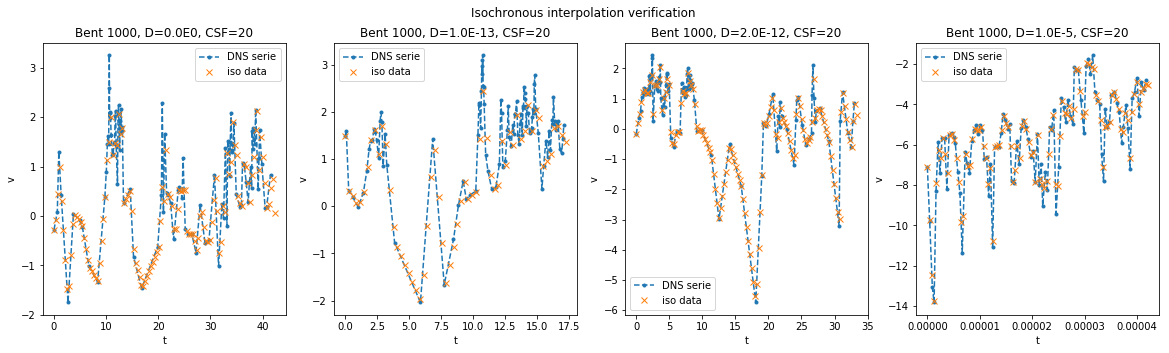

In [ ]:
key    = KEYS[-1]
fig, axs = plt.subplots(1,4, figsize = (20,5))
fig.suptitle('Isochronous interpolation verification');

i0  = 0
N   = 100
for (i,key) in zip(range(4),[KEYS[0], KEYS[1],KEYS[5], KEYS[-1]]) :
    T0     = t_ssl[key][i0]
    T      = t_ssl[key][i0+N]
    axs[i].set_title(key)
    axs[i].plot(t_ssl[key][i0:i0+N],v_ssl[key][i0:i0+N],'.--', label = 'DNS serie'); #rough DNS series
    
    i0_iso = int(np.ceil(T0/dt_iso[key]))
    N_iso  = int(np.ceil((T-T0)/dt_iso[key]))
    t_iso  = np.linspace(T0,T,N_iso)
    axs[i].plot(t_iso,v_iso[key][i0_iso:i0_iso+N_iso],'x',label='iso data'); #Isochronous series

    axs[i].set_xlabel('t');
    axs[i].set_ylabel('v');
    axs[i].legend();
plt.savefig(DIR+'Figures/check_iso_transf'+extension)

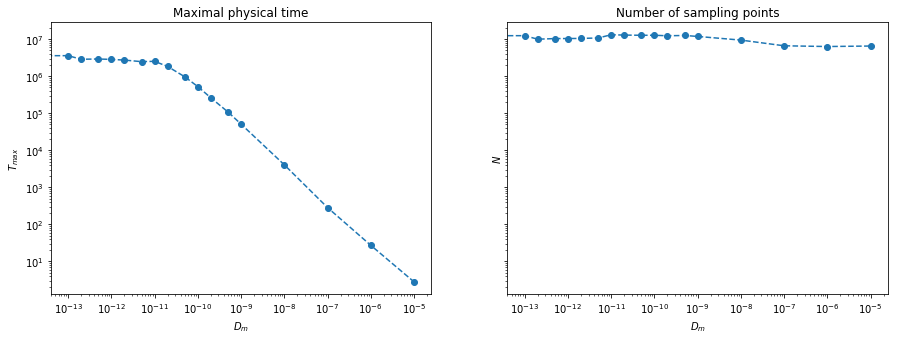

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5), sharey = True);
axs[0].set_title('Maximal physical time');
axs[0].loglog(D_VALUES,[t_ssl[k_][-1] for k_ in KEYS],'--o');
axs[0].set_xlabel(r'$D_m$');
axs[0].set_ylabel(r'$T_{max}$');

axs[1].set_title('Number of sampling points');
axs[1].loglog(D_VALUES,[len(t_ssl[k_]) for k_ in KEYS],'--o');
axs[1].set_xlabel(r'$D_m$');
axs[1].set_ylabel(r'$N$');

### Comparison with Markovian processes

In [ ]:
samples = [Bentheimer1000]
Nmp = 100
MP_params = {
'seed': None,
'v0'  : 1.5,
'dt'  : 0.005,
'Tmax': 300.0,
'csf' : 1.0
}
MP_lvm  = {'params' : MP_params}
fname   = DIR+'Markov_processes/MP_lvm.dat'
rerun   = False
if (not os.path.isfile(fname)) or rerun:
    for sample in samples :
        MP_lvm[sample['name']]  = Parallel(n_jobs=NCORES_MAX)(
            delayed(LVM_process)
            (sample, MP_params) for i in range(Nmp))
        MP_lvm[sample['name']]=np.reshape(MP_lvm[sample['name']],len(MP_lvm[sample['name']][0])*Nmp)
        Save_data(MP_lvm,fname)
else :
    print('Loading data...')
    MP_lvm = Load_data(fname)
    print('Done')

Loading data...


In [ ]:
lvmpdf = Load_pdf(DIR+'Processed_data/bentheimer1000lvmpdf.dat')
fig, axs = plt.subplots(5,2,figsize=(40,15), sharex=True, sharey=True)
sample   = Bentheimer1000
vrange = np.linspace(-10,10,100)
count    = 0
for key in PLOT_KEYS :
    data1 = vDNS[key]
    data2 = v_iso[key]
    data3 = MP_lvm[sample['name']]
    (i,j) = (int(count/2),np.mod(count,2))
    axs[i,j].set_title('' + key)
    axs[i,j].hist(data1, bins = 200, label = key+' DNS',         density = True, alpha= 0.5)
    axs[i,j].hist(data2, bins = 200, label = key+' Isochronous', density = True, alpha= 0.5)
    axs[i,j].hist(data3, bins = 200, label = 'Markov process',   density = True, alpha= 0.5)
    axs[i,j].plot(vrange, p_skew(vrange,sample), label = 'SNP for Benth1000');
    axs[i,j].plot(lvmpdf['Bentheimer1000'][0], lvmpdf['Bentheimer1000'][1], '--k', label = 'Field lvm pdf', alpha=0.7);
    axs[i,j].grid(True)
    axs[i,j].set_xlabel('v')
    axs[i,j].set_ylabel('p(v)')
    axs[i,j].legend()
    axs[i,j].set_xlim([-8,4])
    count += 1
del data1, data2, data3
plt.savefig(DIR+'Figures/summary'+extension)